# **Text Translation with MarianMT**

This notebook demonstrates the implementation of a text translation model from English to Spanish using the [``Helsinki-NLP/opus-mt-en-es``](https://huggingface.co/Helsinki-NLP/opus-mt-en-es) model, available on [Hugging Face 🤗](https://huggingface.co/). This model is a variant of [MarianMT](https://huggingface.co/docs/transformers/model_doc/marian) fine-tuned with the [OPUS eng-spa dataset](https://github.com/Helsinki-NLP/Tatoeba-Challenge/blob/master/models/eng-spa/README.md). To further enhance performance and compare results with the [LSTM with Attention model](https://github.com/JersonGB22/Translation-TensorFlow/blob/main/models_lstm/TranslationEN-ES_LSTMAttention_ManyThings.ipynb), a second fine-tuning is performed using the [ManyThings dataset](https://www.manythings.org/anki/), specifically focusing on the Spanish-English pair, which currently contains 141,543 records.

Hugging Face is renowned for its platform focused on developing tools and models for natural language processing (NLP). Its open-source library, Transformers, facilitates working with advanced pre-trained NLP models such as BERT, T5, GPT, among others.

## **Imports**

In [ ]:
# Install the libraries to evaluate the translation
!pip install evaluate -q
!pip install sacrebleu -q

# Install the Hugging Face datasets library
!pip install datasets -q

In [2]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from datasets import Dataset
from evaluate import load
import numpy as np
import re
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
import textwrap
from tqdm.auto import tqdm

## **Parameters**

In [3]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
model_name = "Helsinki-NLP/opus-mt-en-es"
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
epochs = 5

## **Load and Preprocess the Dataset**

In [ ]:
data_url = "https://www.manythings.org/anki/spa-eng.zip"

# Download dataset
!wget -q $data_url

# Unzip the dataset
!unzip -q /content/spa-eng.zip

In the dataset, the initial records are short and progressively increase in length, so the later records are longer.

In [ ]:
def load_data(path):
  contexts, targets = [], []
  with open(path, "r") as file:
    for line in file:
      line = line.split("\t")
      contexts.append(line[0])
      targets.append(line[1])

  dataset = Dataset.from_dict({
      "en": contexts,
      "es": targets
  })
  return dataset

In [ ]:
dataset = load_data("/content/spa.txt")
dataset

Dataset({
    features: ['en', 'es'],
    num_rows: 141543
})

In [ ]:
# Viewing the first 10 examples
print(dataset[:10])

{'en': ['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Run!', 'Run!', 'Run!', 'Run!', 'Run!'], 'es': ['Ve.', 'Vete.', 'Vaya.', 'Váyase.', 'Hola.', '¡Corre!', '¡Corran!', '¡Huye!', '¡Corra!', '¡Corred!']}


### **Text Tokenization**

The [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) from Hugging Face is used for tokenization, allowing the creation of a tokenizer instance based solely on the model's name. In this translation task, both the source and target language texts are tokenized. The tokenizer outputs `input_ids` (tokens of the English text), `attention_mask` (a mask to ignore padding token indices), and `labels` (tokens of the Spanish text, appropriately prepared for training).

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

MarianTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-es', vocab_size=65001, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	65000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# Example of tokenization

id = -1
example = dataset[id]
encoding = tokenizer(example["en"], text_target=example["es"])

input_ids = encoding["input_ids"]
print(f"Input Ids:\n{input_ids}\n")
print(f"Tokens:\n{tokenizer.convert_ids_to_tokens(input_ids)}\n")
print(f"Decoded Text without Special Tokens:\n{textwrap.fill(tokenizer.decode(input_ids, skip_special_tokens=True), width=100)}\n")
print(f"Attention Mask:\n{encoding['attention_mask']}\n\n")

labels = encoding["labels"]
print(f"Label:\n{labels}\n")
print(f"Tokens:\n{tokenizer.convert_ids_to_tokens(labels)}\n")
print(f"Decoded Text without Special Tokens:\n{textwrap.fill(tokenizer.decode(labels, skip_special_tokens=True), width=100)}")

Input Ids:
[1079, 502, 2, 33, 30181, 141, 13, 634, 27, 386, 115, 882, 4534, 35, 125, 1883, 3, 33, 36149, 96, 48, 843, 3, 42, 1063, 502, 2, 33, 908, 27, 386, 115, 882, 48, 450, 35, 125, 1883, 2, 147, 33, 36149, 96, 48, 843, 903, 3, 639, 5, 1118, 502, 2, 208, 33, 908, 27, 386, 115, 882, 4534, 450, 35, 125, 1883, 903, 2, 33, 1845, 13, 965, 386, 65, 119, 327, 3, 335, 20, 9, 969, 33, 65, 8, 38410, 3, 0]

Tokens:
['▁One', '▁day', ',', '▁I', '▁woke', '▁up', '▁to', '▁find', '▁that', '▁God', '▁had', '▁put', '▁hair', '▁on', '▁my', '▁face', '.', '▁I', '▁shave', 'd', '▁it', '▁off', '.', '▁The', '▁next', '▁day', ',', '▁I', '▁found', '▁that', '▁God', '▁had', '▁put', '▁it', '▁back', '▁on', '▁my', '▁face', ',', '▁so', '▁I', '▁shave', 'd', '▁it', '▁off', '▁again', '.', '▁On', '▁the', '▁third', '▁day', ',', '▁when', '▁I', '▁found', '▁that', '▁God', '▁had', '▁put', '▁hair', '▁back', '▁on', '▁my', '▁face', '▁again', ',', '▁I', '▁decided', '▁to', '▁let', '▁God', '▁have', '▁his', '▁way', '.', '▁That', "'", 

In [ ]:
def tokenization_function(dataset):
  return tokenizer(dataset["en"], text_target=dataset["es"])

In [ ]:
dataset = dataset.map(tokenization_function, batched=True)
dataset

Map:   0%|          | 0/141543 [00:00<?, ? examples/s]

Dataset({
    features: ['en', 'es', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 141543
})

### **Create the training and validation datasets using ``tf.data``**

**Splitting the dataset into training and validation datasets**

In [ ]:
# Take approximately 2000 examples (1.5%) for the evaluation dataset
np.random.seed(SEED) #For reproducibility
is_train = np.random.uniform(size=(len(dataset),)) < 0.985

train_dataset = dataset.filter(lambda sample, id: is_train[id], with_indices=True)
val_dataset = dataset.filter(lambda sample, id: not is_train[id], with_indices=True)

del dataset
len(train_dataset), len(val_dataset)

Filter:   0%|          | 0/141543 [00:00<?, ? examples/s]

Filter:   0%|          | 0/141543 [00:00<?, ? examples/s]

(139424, 2119)

In [ ]:
# Download the MarianMT model
model_base = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

tf_model.h5:   0%|          | 0.00/313M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-es.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

During training, the `DataCollatorForSeq2Seq` is used to dynamically adjust the input size of the model based on the maximum batch length, appropriately adding padding. This data collator returns `input_ids`, `attention_mask`, `decoder_input_ids` (tokens for the model decoder's input, starting with a padding token followed by labels), and `labels` (where padding tokens are marked with -100 to exclude them from loss calculation during training). Subsequently, the datasets are converted into TensorFlow datasets (`tf.data.Dataset`) using the `prepare_tf_dataset` method, making them ready for training.

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model_base,
    return_tensors="np"
)

train_dataset_tf = model_base.prepare_tf_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

val_dataset_tf = model_base.prepare_tf_dataset(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [ ]:
# Viewing a training batch
for inputs, labels in train_dataset_tf.take(1):
  print(inputs["input_ids"][:2], "\n")
  print(inputs["attention_mask"][:2], "\n")
  print(inputs["decoder_input_ids"][:2], "\n")
  print(labels[:2])

tf.Tensor(
[[ 6028    40   172    74    13   113    27   198    21     0 65000 65000
  65000 65000 65000 65000 65000]
 [ 5266    31   105     7 15980    20     9   470  1557     3     0 65000
  65000 65000 65000 65000 65000]], shape=(2, 17), dtype=int64) 

tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]], shape=(2, 17), dtype=int64) 

tf.Tensor(
[[65000    50  4715    15   448  3263   366   274    21     0 65000 65000
  65000 65000 65000 65000]
 [65000  5266    43   415     4    17  1880  1127     4 15980     3     0
  65000 65000 65000 65000]], shape=(2, 16), dtype=int64) 

tf.Tensor(
[[   50  4715    15   448  3263   366   274    21     0  -100  -100  -100
   -100  -100  -100  -100]
 [ 5266    43   415     4    17  1880  1127     4 15980     3     0  -100
   -100  -100  -100  -100]], shape=(2, 16), dtype=int64)


## **Creation and Training of the Model**

In this case, only the GPU of Google Colab is used, not the TPU, because the MarianMT tokenizer is not compatible with the Colab TPU. Additionally, the small size of the dataset (approximately 140K records) and the small size of the model (approximately 68M parameters) are taken advantage of. A custom loss and custom accuracy are also implemented to exclude the padding from labels (-100).

In [ ]:
def masked_loss(labels, logits):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE
  )

  loss = loss_fn(tf.nn.relu(labels), logits)
  mask = tf.cast(labels != -100, loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_accuracy(y_true, y_pred):
  y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
  mask = tf.cast(y_true != -100, tf.float32)
  accuracy = tf.cast(y_true == y_pred, tf.float32)
  accuracy *= mask

  return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

In [ ]:
def create_model():
  input_ids = tf.keras.Input((None, ), dtype=tf.int64, name="input_ids")
  attention_mask = tf.keras.Input((None, ), dtype=tf.int64, name="attention_mask")
  decoder_input_ids = tf.keras.Input((None, ), dtype=tf.int64, name="decoder_input_ids")

  x = model_base(
      input_ids=input_ids,
      attention_mask=attention_mask,
      decoder_input_ids=decoder_input_ids
  ).logits

  model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_input_ids], outputs=x)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123)

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 decoder_input_ids (InputLa  [(None, None)]               0         []                            
 yer)                                                                                             
                                                                                              

In [ ]:
# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.AdamW(2e-5, weight_decay=0.01),
    loss=masked_loss,
    metrics=[masked_accuracy]
)

In [ ]:
# Callback to stop training early if accuracy does not increase for 2 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
# Train the model

tf.random.set_seed(SEED)
history = model.fit(train_dataset_tf, epochs=epochs, validation_data=val_dataset_tf, callbacks=[callback])

Epoch 1/5
4357/4357 [==============================] - 1458s 313ms/step - loss: 0.5498 - masked_accuracy: 0.8534 - val_loss: 0.5031 - val_masked_accuracy: 0.8607
Epoch 2/5
4357/4357 [==============================] - 1359s 312ms/step - loss: 0.4624 - masked_accuracy: 0.8688 - val_loss: 0.5049 - val_masked_accuracy: 0.8596
Epoch 3/5
4357/4357 [==============================] - 1353s 311ms/step - loss: 0.4080 - masked_accuracy: 0.8796 - val_loss: 0.5134 - val_masked_accuracy: 0.8604


**Save model**

In [7]:
trained_model_path = "/content/drive/MyDrive/models/TranslationEN-ES_MarianMT_ManyThings"

In [ ]:
model_base.save_pretrained(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset_tf, verbose=0))
print(model.evaluate(val_dataset_tf, verbose=0))

[0.4156530201435089, 0.8793366551399231]
[0.50312340259552, 0.860670804977417]


Conventional accuracy (``train_dataset: 87.93%, val_dataset: 86.07%``) does not accurately reflect the true performance of the translation model, but it serves as a useful approximation during training to assess how well the model is performing. For a more accurate evaluation, the **BLEU** metric will be used.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()
plot_metrics(metric="masked_accuracy")

**Images for GitHub**

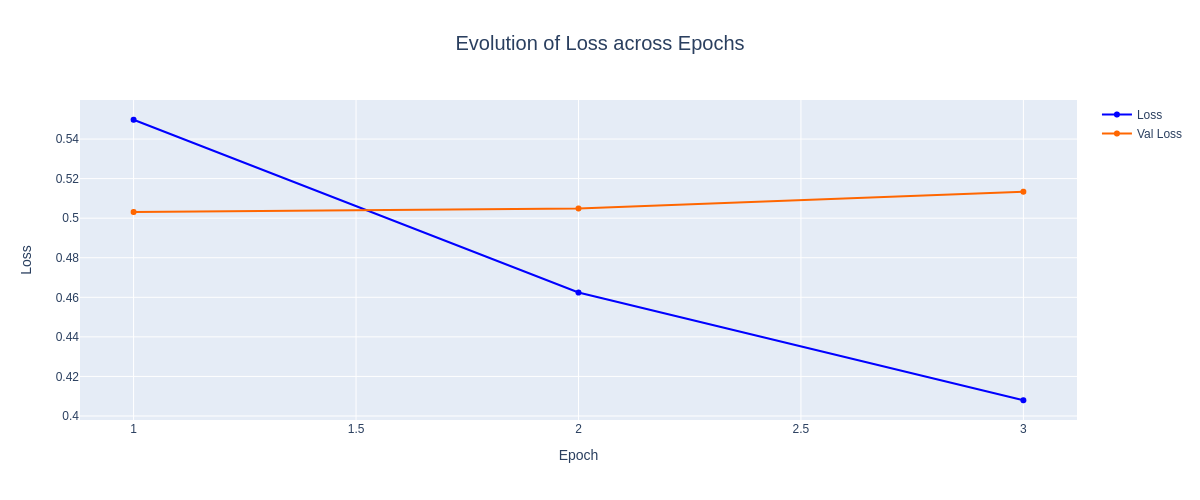

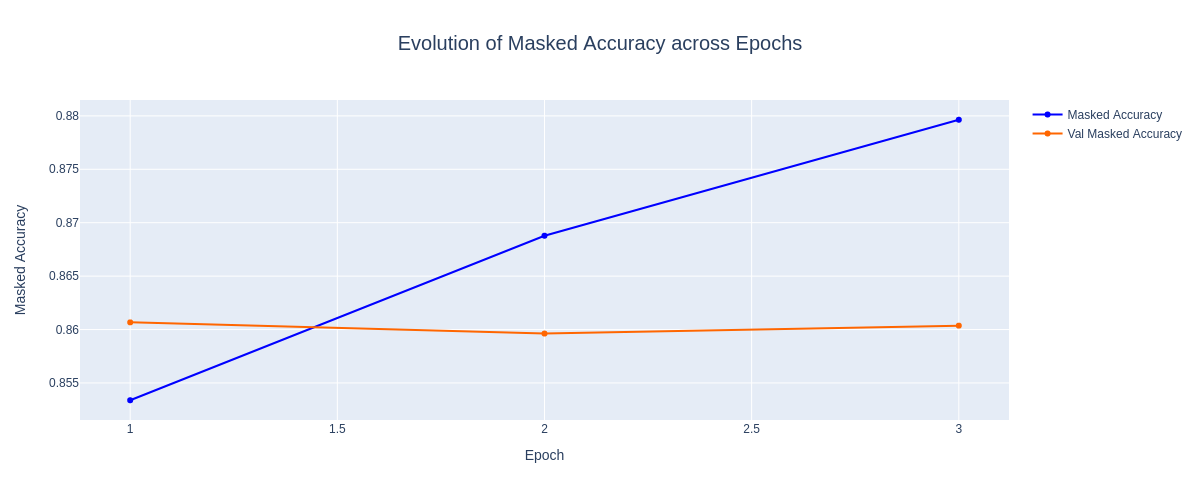

In [ ]:
plot_metrics(renderer="png")
plot_metrics(metric="masked_accuracy", renderer="png")

### **With BLEU Score**

[BLEU (Bilingual Evaluation Understudy)](https://huggingface.co/spaces/evaluate-metric/bleu) is an algorithm used to evaluate the quality of automatically translated text between languages. It uses a scoring range from 0 to 100, where a score of 100 represents a perfect translation. Evaluations are performed on individual translated segments by comparing them to a set of high-quality reference translations.

To facilitate the evaluation of machine translation models using BLEU, [SacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu) is employed. SacreBLEU is a specific implementation of BLEU within the SacreBLEU library, which provides additional tools and specific adjustments to simplify and standardize the evaluation of machine translations.

**Load the Evaluation Metric**

In [8]:
metric = load("sacrebleu")
metric

EvaluationModule(name: "sacrebleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'e

**Function to calculate BLEU score given a list of texts and a list with their reference or references**

In [ ]:
def evaluate_bleu_score(dataset):
  list_predictions, list_references, list_scores = [], [], []

  for i in tqdm(range(0, len(dataset["en"]), batch_size)):
    contexts = dataset["en"][i: i+batch_size]
    targets = dataset["es"][i: i+batch_size]

    inputs = tokenizer(contexts, padding=True, pad_to_multiple_of=32, return_tensors="tf")
    predictions = model_base.generate(**inputs, max_length=256)
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Add a space to the right of the ¿¡ signs, as the metric does not tokenize them properly
    predictions = [re.sub(r"([¿¡])", r"\1 ", p) for p in predictions]
    references = [[re.sub(r"([¿¡])", r"\1 ", t)] for t in targets]

    scores = [
        metric.compute(predictions=[pred], references=[ref], use_effective_order=True)["score"]
        for pred, ref in zip(predictions, references)
    ]

    list_predictions += predictions
    list_references += references
    list_scores += scores

  return list_predictions, list_references, list_scores

In [ ]:
# Calculating the BLEU score for the evaluation dataset
predictions, references, scores = evaluate_bleu_score(val_dataset)
print(f"BLEU Score: {np.mean(scores)}")

  0%|          | 0/67 [00:00<?, ?it/s]

BLEU Score: 57.686828873112006


In [ ]:
metric.compute(predictions=predictions, references=references)

{'score': 58.22083109192648,
 'counts': [12191, 8286, 5739, 3902],
 'totals': [15220, 13101, 10982, 8871],
 'precisions': [80.09855453350855,
  63.24708037554385,
  52.25824075760335,
  43.98602186901139],
 'bp': 0.9966547537070007,
 'sys_len': 15220,
 'ref_len': 15271}

The BLEU score of the model on the evaluation dataset is **57.69**. This value, calculated individually, is more accurate due to the use of the argument `use_effective_order=True`, which only considers n-grams that match the length of the evaluated text. On the other hand, the aggregate calculation yields a score of **58.22**, which is slightly less precise. This discrepancy occurs because when sequences are shorter than the n-grams considered by the metric, a score of 0 is assigned, even if the prediction and the reference are identical.

A BLEU score of 57.69 indicates that the model produces translations of medium to high quality. It is important to note that this score might be higher if the evaluation dataset had multiple references for each entry, as there are often several possible translations when switching languages, especially for very long texts. As we will see later when generating translations, the model is excellent even with long or very long texts, suggesting that its BLEU score should reflect high quality.

In comparison to the LSTM with Attention model (BLEU score of 37.33), which was only good for short or medium texts, the Transformer model shows a significant improvement.

## **Translate from English to Spanish**

In [9]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForSeq2SeqLM.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /content/drive/MyDrive/models/TranslationEN-ES_MarianMT_ManyThings.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [23]:
# Function to generate translations and display them in HTML format
def display_translation(text, reference=None, max_length=256):
  inputs = tokenizer([text], return_tensors="tf")
  pred = model.generate(**inputs, max_length=max_length)
  pred = tokenizer.decode(pred[0], skip_special_tokens=True)

  if reference is not None:
    score = metric.compute(
        predictions=[re.sub(r"([¿¡])", r"\1 ", pred)],
        references=[[re.sub(r"([¿¡])", r"\1 ", ref) for ref in reference]],
        use_effective_order=True
    )["score"]

    display(HTML(f"""
    <div style="width: 700px;">
      <b>English Text:</b> {text}<br><br>
      <b>Spanish Translation:</b> {pred}<br><br>
      <b>Reference Translations:</b> {reference}<br><br>
      <b><span style="color: blue">BLEU Score:</span></b> {round(score, 2)}
    </div>
    """))

  else:
    display(HTML(f"""
    <div style="width: 700px;">
      <b>English Text:</b> {text}<br><br>
      <b>Spanish Translation:</b> {pred}
    </div>
    """))

In [33]:
# Without references
display_translation("See you later.")

In [32]:
display_translation(
    text="I was born in Spain.",
    reference=["Nací en España.", "Yo nací en España"]
)

In [31]:
display_translation(
    text="How old are you?",
    reference=["¿Cuántos años tienes?"]
)

In [30]:
display_translation(
    text="Where are you from?",
    reference=["¿De qué lugar eres?", "¿De dónde eres?", "¿De dónde sos?"]
)

In [29]:
display_translation(
    text="You did an excellent job!",
    reference=["¡Hiciste un excelente trabajo!"]
)

In [28]:
display_translation(
    text="I like to learn, that's why I study at the university.",
    reference=["Me gusta aprender, por eso estudio en la universidad."]
)

In [27]:
display_translation(
    text="Tomorrow, we will visit our grandparents who live in the countryside.",
    reference=[
        "Mañana visitaremos a nuestros abuelos que viven en el campo.",
        "Mañana vamos a visitar a nuestros abuelos que viven en el campo.",
    ]
)

In [82]:
display_translation(
    text="In what ways can artificial intelligence improve healthcare delivery and patient outcomes?",
    reference=["¿De qué maneras la inteligencia artificial puede mejorar la atención médica y los resultados de los pacientes?"]
)

In [74]:
display_translation(
    text="I enjoy watching horror movies and science fiction series in my free time.",
    reference=["Me gusta ver películas de terror y series de ciencia ficción en mi tiempo libre."]
)

**Long Texts**

In [50]:
display_translation(
    text="When she arrived at the train station, she realized she had forgotten her ticket at home and had to rush back to retrieve it.",
    reference=[
        "Cuando llegó a la estación de tren, ella se dio cuenta de que había olvidado su boleto en casa y tuvo que volver corriendo a buscarlo.",
        "Cuando llegó a la estación de tren, se dio cuenta de que había olvidado su boleto en casa y tuvo que volver corriendo para recuperarlo.",
        "Al llegar a la estación de tren, se dio cuenta de que había dejado su billete en casa y tuvo que regresar apresuradamente para buscarlo."
    ]
)

To accurately calculate the BLEU score for long text translations, multiple references are needed. Otherwise, it can result in situations like the following example: there is only one reference, but the translation is equivalent and very good, yet it only achieves a score of 51.45 when it should be 100 or very close to it.

In [51]:
display_translation(
    text="In ten years, he will have his own company, will have become a successful professional worldwide, and will be helping many people in his country.",
    reference=["En diez años, él tendrá su propia empresa, se habrá convertido en un profesional exitoso a nivel mundial y estará ayudando a muchas personas en su país."]
)

In [55]:
display_translation(
    text="Globalization has interconnected economies around the world, fostering trade, cultural exchange, and international cooperation.",
    reference=[
        "La globalización ha interconectado las economías de todo el mundo, fomentando el comercio, el intercambio cultural y la cooperación internacional.",
        "La globalización ha interconectado las economías alrededor del mundo, fomentando el comercio, el intercambio cultural y la cooperación internacional.",
        "La globalización ha conectado las economías a nivel mundial, promoviendo el comercio, el intercambio cultural y la cooperación internacional."
    ]
)

In [59]:
display_translation(
    text="Social media platforms have reshaped communication patterns, connecting people globally while also raising concerns about privacy and digital security.",
    reference=[
        "Las plataformas de redes sociales han transformado los patrones de comunicación, conectando a las personas a nivel global pero también generando preocupaciones sobre la privacidad y la seguridad digital.",
        "Las plataformas de redes sociales han remodelado los patrones de comunicación, conectando a las personas globalmente mientras también suscitan preocupaciones sobre la privacidad y la seguridad digital.",
        "Las redes sociales han transformado los patrones de comunicación, conectando a las personas a nivel global, al mismo tiempo que plantean preocupaciones sobre la privacidad y la seguridad digital."
    ]
)

In [65]:
display_translation(
    text="The future of artificial intelligence is both thrilling and uncertain! Advancements in AI are revolutionizing industries across the globe, but ethical concerns remain a pressing issue.",
    reference=[
        "¡El futuro de la inteligencia artificial es emocionante y al mismo tiempo incierto! Los avances en IA están revolucionando industrias en todo el mundo, pero las preocupaciones éticas siguen siendo una cuestión apremiante.",
        "El futuro de la inteligencia artificial es tanto emocionante como incierto! Los avances en IA están transformando industrias en todo el mundo, pero las preocupaciones éticas siguen siendo un asunto urgente.",
        "¡El futuro de la inteligencia artificial es emocionante e incierto! Los avances en IA están revolucionando industrias en todo el mundo, pero las preocupaciones éticas siguen siendo una preocupación apremiante."
    ]
)

**Very long texts**

For these texts, the BLEU score will no longer be calculated, as a large number of references would be required. However, as will be seen below, the translation is excellent!

In [60]:
display_translation(
    text="The trip had been planned for months, and now it was finally happening. John and his family were embarking on a cross-country road trip, a journey that promised adventure and discovery. They had mapped out their route, with stops at various national parks, historical landmarks, and charming small towns. Each day brought new experiences: hiking through dense forests, marveling at the vastness of the Grand Canyon, and exploring the cultural heritage of different regions. They stayed in cozy cabins, tried local cuisines, and met people with fascinating stories. One memorable night, they camped under the stars in a remote area, the sky a canvas of twinkling lights that seemed to stretch on forever. As they sat around the campfire, roasting marshmallows and sharing stories, John felt a deep bond with his family, strengthened by the shared experiences and the beauty of the world around them. This trip was more than just a vacation; it was a journey of growth, learning, and togetherness that they would remember for the rest of their lives."
)

In [61]:
display_translation(
    text="In the heart of the forest, where the ancient trees stood tall and proud, a hidden world thrived in the shadows. This was a place untouched by the passage of time, where nature reigned supreme and the delicate balance of the ecosystem remained unbroken. The air was filled with the sounds of wildlife, from the chirping of birds to the rustling of leaves as small creatures scurried about. Sunlight filtered through the dense canopy, casting dappled patterns on the forest floor. It was a serene and magical environment, a stark contrast to the bustling human world outside. Here, amidst the towering trees and lush undergrowth, one could find a sense of peace and solitude. As they wandered deeper into the forest, they discovered hidden streams and glades, places where the beauty of nature was on full display. Each step taken revealed new wonders, from the vibrant colors of wildflowers to the intricate designs of spider webs glistening with dew. This forest was a sanctuary, a reminder of the natural world's enduring beauty and resilience."
)

In [62]:
display_translation(
    text="""The Renaissance was a fervent period of European cultural, artistic, political, and economic "rebirth" following the Middle Ages. Generally described as taking place from the 14th century to the 17th century, the Renaissance promoted the rediscovery of classical philosophy, literature, and art. Some of the greatest thinkers, authors, statesmen, scientists, and artists in human history thrived during this era, while global exploration opened up new lands and cultures to European commerce. The Renaissance is credited with bridging the gap between the Middle Ages and modern-day civilization. It began in Florence, Italy, in the 14th century and spread to the rest of Europe in the following centuries. The movement had a profound impact on art, architecture, science, and literature. Artists such as Leonardo da Vinci and Michelangelo created works that are still revered today. The Renaissance also saw the invention of the printing press, which allowed for the spread of knowledge and ideas to a wider audience. This period of history laid the groundwork for many aspects of modern society."""
)

**Conclusion:**

The model is excellent for English to Spanish translations, covering from short texts to very long ones, and achieving a high BLEU score in its translations. Its performance might improve even further with models that have more parameters and with larger datasets with multiple references. In this way, it could even translate entire pages of text with high quality. However, for translating a few paragraphs, the model is already more than sufficient and excellent.